
#In this notebook I will compare perform of 3 models Unet, Segnet, Unet with attention in task of Face Semantic Segmentation, Using Celeba Dataset

#Data import + creating a DataFrame

In [1]:
!pip install torchmetrics
import torch
import os
import torchvision
from torchvision import transforms
import gdown
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import gc
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 11.6 MB/s eta 0:00:00


In [ ]:
#downloading dataset
sharing_link = "https://drive.google.com/file/d/1XAvdeLwZLxvvRDNGYPSoqi_UgbDho9nZ/view?usp=sharing"
gdown.download(url=sharing_link, output="./data.zip", quiet=False, fuzzy=True)
!unzip ./data.zip

In [3]:
!ls CelebAMask-HQ

CelebA-HQ-img			  CelebAMask-HQ-mask-anno
CelebA-HQ-to-CelebA-mapping.txt   CelebAMask-HQ-pose-anno.txt
CelebAMask-HQ-attribute-anno.txt  README.txt


In [4]:
import os
#gets all images in folder
def get_image(folder,path):
  folder_path = path+str(folder)
  print(folder_path)
  a = os.listdir(folder_path)
  a.sort()
  return a


In [5]:
segments = {} #collect all links for images
labels = {}
orig = []
for i in range(15):
  folder_path = "CelebAMask-HQ/CelebAMask-HQ-mask-anno/"
  files = get_image(i,folder_path) #get images
  #print(files)
  for name in files:
    if name=='.DS_Store':
      continue
    idx = str(int(name.split('_')[0])) #correct name '0' instead of '0000'
    if segments.get(idx):
      segments[idx].append(folder_path+str(i)+'/'+name)
      labels[idx].append(name[6:].split('.')[0])
    else:
      segments[idx] = [folder_path+str(i)+'/'+name]
      labels[idx] = [name[6:].split('.')[0]]
orig = [f'CelebAMask-HQ/CelebA-HQ-img/{idx}.jpg' for idx in range(15*2000)]
segments = [segments[str(idx)] for idx in range(15*2000)]
labels = [labels[str(idx)] for idx in range(15*2000)]

CelebAMask-HQ/CelebAMask-HQ-mask-anno/0
CelebAMask-HQ/CelebAMask-HQ-mask-anno/1
CelebAMask-HQ/CelebAMask-HQ-mask-anno/2
CelebAMask-HQ/CelebAMask-HQ-mask-anno/3
CelebAMask-HQ/CelebAMask-HQ-mask-anno/4
CelebAMask-HQ/CelebAMask-HQ-mask-anno/5
CelebAMask-HQ/CelebAMask-HQ-mask-anno/6
CelebAMask-HQ/CelebAMask-HQ-mask-anno/7
CelebAMask-HQ/CelebAMask-HQ-mask-anno/8
CelebAMask-HQ/CelebAMask-HQ-mask-anno/9
CelebAMask-HQ/CelebAMask-HQ-mask-anno/10
CelebAMask-HQ/CelebAMask-HQ-mask-anno/11
CelebAMask-HQ/CelebAMask-HQ-mask-anno/12
CelebAMask-HQ/CelebAMask-HQ-mask-anno/13
CelebAMask-HQ/CelebAMask-HQ-mask-anno/14


In [6]:
data = {'orig_link':orig,'segment_link':segments,'label':labels}
df = pd.DataFrame(data=data)
df.head()

,orig_link,segment_link,label
0,CelebAMask-HQ/CelebA-HQ-img/0.jpg,[CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/00000...,"[hair, l_brow, l_eye, l_lip, mouth, neck, nose..."
1,CelebAMask-HQ/CelebA-HQ-img/1.jpg,[CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/00001...,"[cloth, hair, l_brow, l_ear, l_eye, l_lip, mou..."
2,CelebAMask-HQ/CelebA-HQ-img/2.jpg,[CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/00002...,"[ear_r, hair, l_brow, l_ear, l_eye, l_lip, nec..."
3,CelebAMask-HQ/CelebA-HQ-img/3.jpg,[CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/00003...,"[hair, l_brow, l_eye, l_lip, mouth, neck, nose..."
4,CelebAMask-HQ/CelebA-HQ-img/4.jpg,[CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/00004...,"[cloth, hair, l_brow, l_ear, l_eye, l_lip, mou..."


In [7]:
df_train, df_test = df.iloc[:25000], df.iloc[25000:]
df_test.reset_index(drop=True,inplace=True)

#Dataloader with augmentations

In [8]:
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A

class FaceDataSet(Dataset):

  def __init__(self,data_frame,type_df='train'):
    self.df = data_frame
    self.type_df = type_df
    self.aug = A.Compose([
    A.Resize(height=256,width=256, p = 1),
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(64, 256), height=256, width=256, p=0.5),
        A.PadIfNeeded(min_height=256, min_width=256, p=0.5)
    ],p=0.4),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf(
        [
        A.ElasticTransform(p=1, alpha=120/2, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.8)
    ])

    self.transform_tensor = transforms.Compose([transforms.ToTensor(),
                                                ])
    self.transform_test =  transforms.Compose([ transforms.Resize(256),
                                                transforms.ToTensor()
                                                ])
    self.truth = self.df['orig_link']
    self.segments_links = self.df['segment_link']
    self.labels = self.df['label']

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      unique_labels = ['hair', 'l_brow', 'l_eye', 'l_lip', 'mouth', 'neck', 'nose','r_brow', 'r_eye', 'skin', 'u_lip', 'cloth', 'l_ear', 'r_ear',
       'ear_r', 'hat', 'neck_l', 'eye_g']
      orig_img_test = self.transform_test(Image.open(self.truth[idx]))
      orig_img = np.array(Image.open(self.truth[idx]))
      mask = np.zeros([512,512,18])
      mask_test = np.zeros([18,256,256])
      for i,(image,label) in enumerate(zip(self.segments_links[idx],self.labels[idx])):
        array = np.array(Image.open(image))
        mask[:,:,unique_labels.index(label)] = array[:,:,0]//255
        tensor = self.transform_test(Image.open(image))
        mask_test[unique_labels.index(label),:,:] = (tensor[0,:,:]==1)

      if self.type_df == 'train':
        augmented = self.aug(image=orig_img, mask=mask)
        augmented_img = augmented['image']
        augmented_mask = augmented['mask']
        augmented_img = self.transform_tensor(augmented_img.astype(np.float32) / np.max(augmented_img))
        augmented_mask = self.transform_tensor((augmented_mask.astype(np.float32)))
        return  augmented_mask, augmented_img,orig_img, mask    # shape [batch,num_classes,256,256]

      else:

        return orig_img_test,mask_test


In [9]:
from torch.utils.data import Dataset, DataLoader
batch_size = 8
train_dataset = FaceDataSet(df_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
aug_mask, aug_img, orig, mask = next(iter(train_dataloader))

In [10]:
def mask_to_plot(aug_mask):
  mask = np.array(aug_mask)
  size = min(mask.shape)
  pix = mask.shape[1]
  mask_ = np.zeros([1,pix,pix])
  for i in range(18):
    if pix==512:
      mask_[0,:,:] += mask[:,:,i]
    else:
      mask_[0,:,:] += np.array(mask[i,:,:])
  return mask_.transpose(1,2,0)

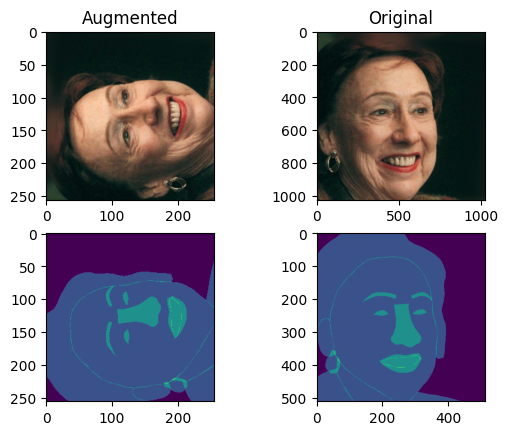

In [11]:
# create the subplots
fig, axs = plt.subplots(2, 2)
ten = transforms.ToTensor()

# plot each subplot
axs[0,0].imshow(np.transpose(np.array(aug_img[3]),(1,2,0)))
axs[0,0].set_title('Augmented')
axs[0,1].imshow(orig[3])
axs[0,1].set_title('Original')
axs[1,0].imshow(mask_to_plot(aug_mask[3]))
axs[1,1].imshow(mask_to_plot(mask[3]))

#Models

In [12]:
from torch import nn

#Unet
class Encoder_Block(torch.nn.Module):
  def __init__(self,inp_channels,out_channels):
    super().__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
    )
    self.pooling = torch.nn.MaxPool2d(2)
  def forward(self,x):
    int_out = self.model(x)
    return self.pooling(int_out), int_out

class Decoder_Block(torch.nn.Module):
  def __init__(self,inp_channels,out_channels):
    super().__init__()
    self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
    )
  def forward(self,x,enc_x):
    x = self.upsample(x)
    x = torch.cat([x,enc_x],dim=1)
    return self.model(x)

class Unet(torch.nn.Module):
  def __init__(self,inc,outc,hidden_size=64):
    super().__init__()
    self.Encoder = torch.nn.ModuleList([
        Encoder_Block(inc,hidden_size),
        Encoder_Block(hidden_size,hidden_size*2),
        Encoder_Block(hidden_size*2,hidden_size*4),
        Encoder_Block(hidden_size*4,hidden_size*8),
    ])
    self.bottleneck = torch.nn.Sequential(
        torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
        torch.nn.BatchNorm2d(hidden_size*16),
        torch.nn.ReLU(),
        torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
        torch.nn.BatchNorm2d(hidden_size*16),
        torch.nn.ReLU()
    )
    self.Decoder = torch.nn.ModuleList([
        Decoder_Block(hidden_size*16,hidden_size*8),
        Decoder_Block(hidden_size*8,hidden_size*4),
        Decoder_Block(hidden_size*4,hidden_size*2),
        Decoder_Block(hidden_size*2,hidden_size*1),
    ])
    self.last_layer = torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same")
  def forward(self,x):
    enc_xs = []
    for module in self.Encoder:
      x, enc_x= module(x)
      enc_xs.append(enc_x)

    enc_xs = enc_xs[::-1]
    x = self.bottleneck(x)

    for i,module in enumerate(self.Decoder):
      x = module(x,enc_xs[i])
    return self.last_layer(x)

In [ ]:
# Unet with attention block
class Attention(nn.Module):
    def __init__(self,skip_channels, x_channels):
        super().__init__()
        self.First = nn.Conv2d(skip_channels, skip_channels,kernel_size=2, stride=2)

        self.Second = nn.Conv2d(x_channels, skip_channels,kernel_size=1)
        self.Relu = nn.ReLU()
        self.Third = nn.Conv2d(skip_channels, 1,kernel_size=1)
        self.Sigm = nn.Sigmoid()

    def forward(self,skip,x):
        Conv1 = self.First(skip)
        Conv2 = self.Second(x)
        ReLu = self.Relu(Conv1+Conv2)
        Conv3 = self.Third(ReLu)
        attention = self.Sigm(Conv3)
        attention = nn.functional.interpolate(attention, size=skip.size()[2:], mode='bilinear', align_corners=False)
        attention = attention.expand(skip.size())
        output = skip*attention
        return output

class Decoder_Block_With_Attention(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.attention = Attention(out_channels,inp_channels)
    def forward(self,x,enc_x):
        enc_x = self.attention(enc_x,x)
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)


class AttentionUnet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=16):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block_With_Attention(hidden_size*16,hidden_size*8),
            Decoder_Block_With_Attention(hidden_size*8,hidden_size*4),
            Decoder_Block_With_Attention(hidden_size*4,hidden_size*2),
            Decoder_Block_With_Attention(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same"),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)

In [ ]:
#Segnet
class Encoder(nn.Module):
    def __init__(self, input_channels=3,out_conv=64):
        super(Encoder, self).__init__()
        def conv_l(input_channels,out_conv):
          return nn.Sequential(
            nn.Conv2d(input_channels, out_conv, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_conv, momentum=0.1),
            nn.ReLU(),
            nn.Conv2d(out_conv, out_conv, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_conv, momentum=0.1),
            nn.ReLU()
        )
        self.e_1 = conv_l(input_channels,out_conv)
        self.e_2 = conv_l(out_conv,2*out_conv)
        self.e_3 = conv_l(2*out_conv,4*out_conv)
        self.e_4 = conv_l(4*out_conv,8*out_conv)
        self.e_5 = conv_l(8*out_conv,8*out_conv)


    def forward(self, x):
        id = []
        def mp(x):
          return F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.e_1(x)
        x, id1 = mp(x)
        id.append(id1)
        x = self.e_2(x)
        x, id2 = mp(x)
        id.append(id2)
        x = self.e_3(x)
        x, id3 = mp(x)
        id.append(id3)
        x = self.e_4(x)
        x, id4 = mp(x)
        id.append(id4)
        x = self.e_5(x)
        x, id5 = mp(x)
        id.append(id5)

        return x, id

class Segnet(nn.Module):
    def __init__(self, input_channels=3, output_channels=18,):
        super(Segnet, self).__init__()
        self.encoder = Encoder(input_channels)
        def conv_l(in_channels,out_conv):
          return nn.Sequential(
           nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels, momentum=0.1),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels, momentum=0.1),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_conv, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_conv, momentum=0.1),
            nn.ReLU()
        )

        self.d_1 = conv_l(512,512)
        self.d_2 = conv_l(512,256)
        self.d_3 = conv_l(256,128)

        self.d_4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=0.1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=0.1),
            nn.ReLU()
        )
        self.d_5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=0.1),
            nn.ReLU(),
            nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x, id = self.encoder(x)
        def mp(x,id,n):
          return F.max_unpool2d(x,id[n],kernel_size=2, stride=2)
        x = mp(x,id,4)
        x = self.d_1(x)
        x = mp(x,id,3)
        x = self.d_2(x)
        x = mp(x,id,2)
        x = self.d_3(x)
        x = mp(x,id,1)
        x = self.d_4(x)
        x = mp(x,id,0)
        x = self.d_5(x)

        return x

#Dice and IoU

In [13]:
def calc_IoU(res,mask,device='cuda'):
  mask=mask.to(device)
  res = res.to(device)
  intersection = res*mask
  union = (res+mask).clamp(0,1)

  return ((intersection.sum()+0.0001)/(union.sum()+0.0001)).item()


def calc_Dice(res,mask,device='cuda'):
  mask=mask.to(device)
  res = res.to(device)
  tp = (res*mask).sum()
  fp = (mask[res==1]==0).sum()
  fn = (mask[res==0]==1).sum()

  return ((2*tp+0.00001)/(2*tp+fn+fp+0.00001)).item()

class diceloss(torch.nn.Module):
    def forward(self,pred, target):
       pred = pred.view(-1)
       target = target.view(-1)
       intersection = (pred * target).sum()
       P = torch.sum(pred*pred)#to get only positive values
       T = torch.sum(target)
       return 1 - ((2. * intersection + 0.0001) / (P + T + 0.0001) )

In [17]:
from google.colab import drive
def save_model_torch(model,name='Unet3_1'):
  drive.mount('/content/drive/')
  model_save_name=name
  path=f'/content/drive/MyDrive/models/{model_save_name}'
  torch.save(model.state_dict(), path)
def load_model_torch(model,name='Unet3_18'):
  model = model
  drive.mount('/content/drive/')
  model_save_name=name
  path=f'/content/drive/MyDrive/models/{model_save_name}'
  state_dict = torch.load(path)
  model.load_state_dict(state_dict)
  return model

#Train and Test

In [21]:
from torch.nn import CrossEntropyLoss as CEL
def train(model, dataloaders,
          num_epochs=3, scheduler=None, savename=None,
          device=torch.device("cuda")):
  torch.cuda.empty_cache()
  model.to(device)
  data_t = dataloaders
  opt = torch.optim.Adam(model.parameters(),lr=0.00001)
  criterion=diceloss().to('cuda')
  classes = ['hair', 'l_brow', 'l_eye', 'l_lip', 'mouth', 'neck', 'nose','r_brow', 'r_eye', 'skin', 'u_lip', 'cloth', 'l_ear', 'r_ear',
       'ear_r', 'hat', 'neck_l', 'eye_g']
  #iterate per epoch
  for epoch in range(num_epochs):
    model.train(True)
    loss_ = []
    loss_last = [0]*50
    batch_num = 0
    #iterate per batch
    if epoch>0:
      opt = torch.optim.Adam(model.parameters(),lr=0.000001)
    for  mask, orig, _,_ in tqdm(data_t):
        sum_dice = 0
        sum_iou = 0
        mask, orig = mask.to(device), orig.to(device)
        output = model(orig)
        loss = criterion(output, mask)

        pred = 1*(output>0.5)
        pred.size()
        mask.size()
        for batch in range(orig.shape[0]):
          for i in range(len(classes)):
            dice=calc_Dice(pred[batch][i],mask[batch][i])
            iou=calc_IoU(pred[batch][i],mask[batch][i])
            sum_dice += dice
            sum_iou += iou

        loss_item = loss.detach().item()

        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_last = loss_last[1:]
        loss_last.append(loss_item)

        if (batch_num+1)%100==0 and (batch_num+1)//10 >= 1:
          print(f'Loss: {np.sum(loss_last)/50},IoU:{sum_iou/(batch_size*len(classes))}')
        if (batch_num+1)%500==0 and (batch_num+1)//10 >=1:
          save_model_torch(model,name=f'{savename}_{7+epoch}_{batch_num}_weighted')
        batch_num+=1
  return model

In [25]:
def test(model, dataloaders,
          num_epochs=3, scheduler=None, savename=None,
          device=torch.device("cuda")):
  model.to(device)
  data_t = dataloaders
  classes = ['hair', 'l_brow', 'l_eye', 'l_lip', 'mouth', 'neck', 'nose','r_brow', 'r_eye', 'skin', 'u_lip', 'cloth', 'l_ear', 'r_ear',
       'ear_r', 'hat', 'neck_l', 'eye_g']

  for epoch in range(num_epochs):
    model.eval()
    dict_Dice = {k:[] for k in classes}
    dict_IoU = {k:[] for k in classes}
    batch_num = 0
    pred_=[]
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.memory_reserved()
    id_res = []
    #iterate per batch
    for  orig, mask in tqdm(data_t):

        with torch.no_grad():
          mask, orig = mask.to(device), orig.to(device)
          output = model(orig)

          pred = 1*(output>0.5).to(device)
          #pred_.append(pred)
          sum_dice=0
          sum_iou=0
          for batch in range(batch_size):
            for i in range(len(classes)):
              dice=calc_Dice(pred[batch][i],mask[batch][i])
              iou=calc_IoU(pred[batch][i],mask[batch][i])
              sum_dice += dice
              sum_iou += iou
              dict_Dice[classes[i]].append(dice)
              dict_IoU[classes[i]].append(iou)
          sum_dice = sum_dice/(batch_size*len(classes))
          sum_iou = sum_iou/(batch_size*len(classes))
          id_res.append((batch_num,sum_dice,sum_iou))

        batch_num+=1
  return id_res,dict_Dice, dict_IoU

#Score Compare

First of all lets choose a Loss Function. I decided to compare test score for 2 Losses: Dice, Cross Entropy. As validation metric I will use IoU.
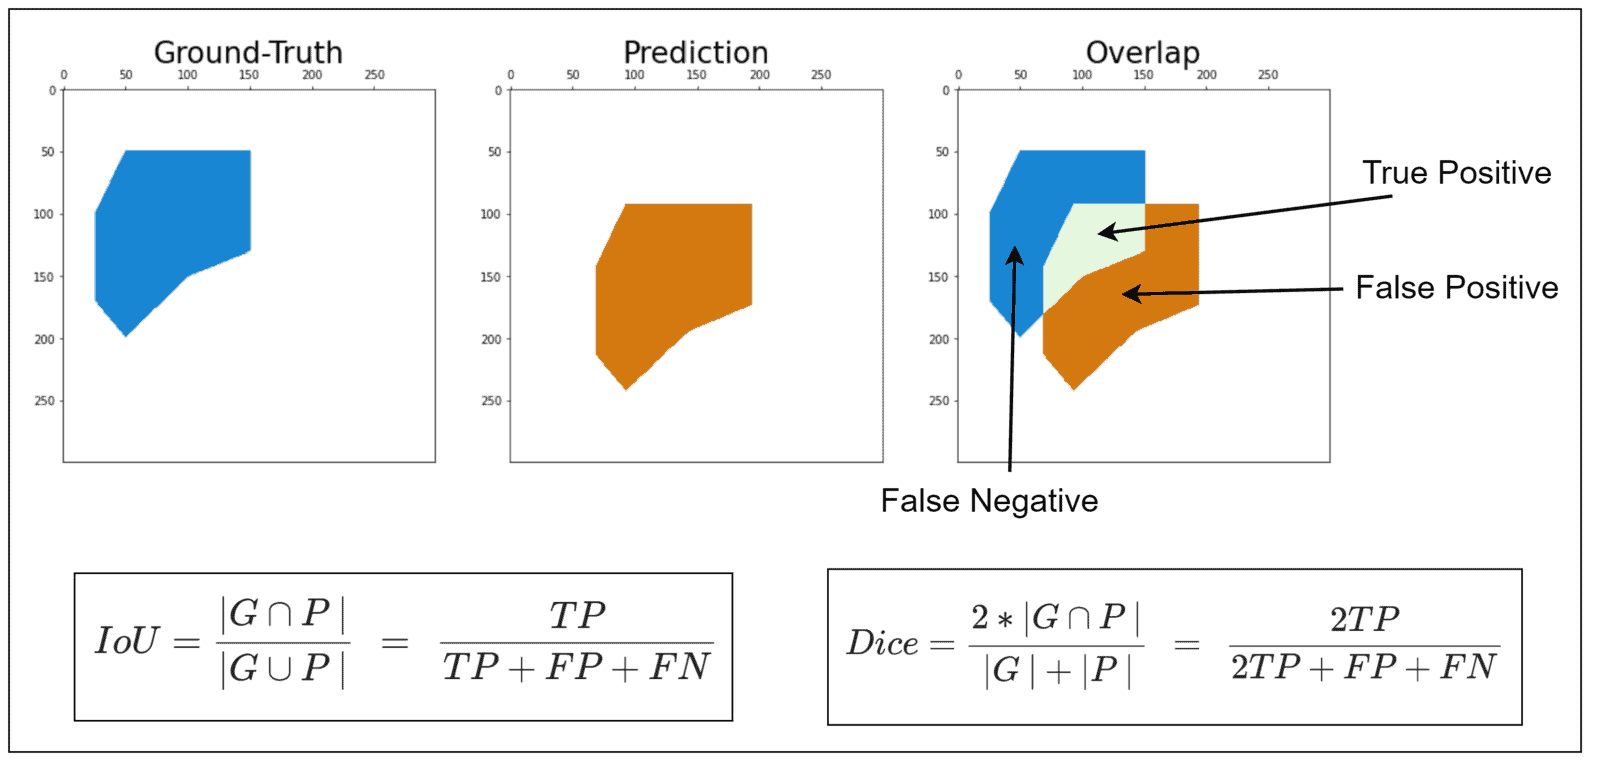

In [49]:
Unet_model = load_model_torch(Unet(3,18),name='Unet_2_0_weighted')
Unet_CEL_model = load_model_torch(Unet(3,18),name='Unet_CEL_2_0_weighted')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [50]:
batch_size = 1
test_dataset = FaceDataSet(df_test,type_df='Test')
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,num_workers=2)

In [51]:
res_Unet, dict_Dice_Unet, dict_IoU_Unet = test(Unet_model,test_dataloader,num_epochs=1)
res_Unet_CEL, dict_Dice_Unet_CEL, dict_IoU_Unet_CEL = test(Unet_CEL_model,test_dataloader,num_epochs=1)

100%|██████████| 5000/5000 [16:45<00:00,  4.97it/s]


In [52]:
def get_DataSet_results(dict_dice, model_name,loss):
  d = {'classes': [],
     f'{loss}' : [],
     'model_name': []}

  for key, value in dict_dice.items():
    d['classes'] += [key] * len(value)
    d[f'{loss}'] += value
    d['model_name'] += [model_name] * len(value)
  df = pd.DataFrame(data=d)
  return df


In [53]:
df_Unet = get_DataSet_results(dict_IoU_Unet, 'Unet','IoU')
df_Unet_CEL = get_DataSet_results(dict_IoU_Unet_CEL, 'Unet_CEL','IoU')

In [54]:
df_loss = pd.concat([df_Unet,df_Unet_CEL])

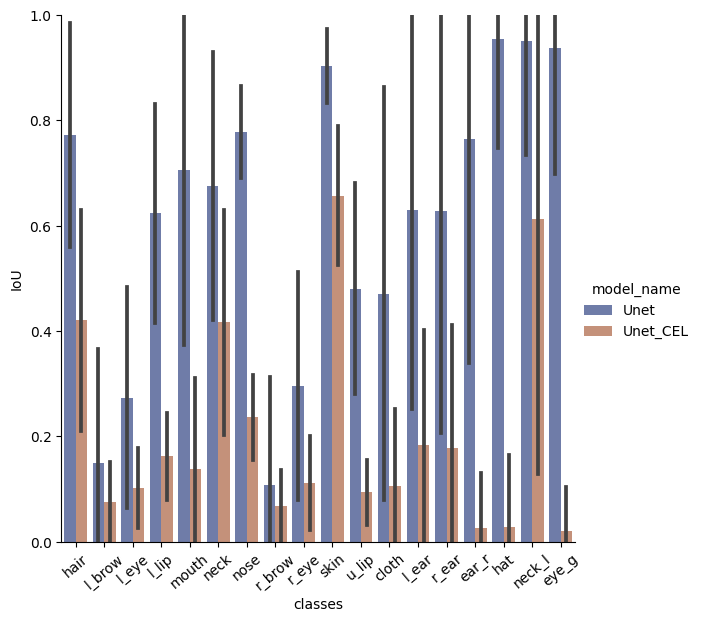

In [55]:
import seaborn as sns
g=sns.catplot(
    data=df_loss, kind="bar",
    x="classes", y="IoU", hue="model_name",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.set_xticklabels(rotation=40)
plt.ylim(0,1)
plt.show()

It's easy to see that for every main part of classes, Dice loss gives better IoU scores thatn Cross Entropy, so next step will be to compare different models trained for 2 epochs on dice loss

#Model Compare

In [ ]:
AttentionUnet_model = load_model_torch(AttentionUnet(3,18),name='AttentionUnet_2_0_weighted')
Segnet_model = load_model_torch(Segnet(3,18),name='Segnet_2_0_weighted')
res_Attention_Unet, dict_Dice_Attention_Unet, dict_IoU_Attention_Unet = test(AttentionUnet_model,test_dataloader,num_epochs=1)
res_Segnet, dict_Dice_Segnet, dict_IoU_Segnet = test(Segnet_model,test_dataloader,num_epochs=1)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


100%|██████████| 5000/5000 [15:44<00:00,  5.29it/s]


In [ ]:
df_Unet = get_DataSet_results(dict_Dice_Unet, 'Unet','Dice')
df_Segnet = get_DataSet_results(dict_Dice_Segnet, 'Segnet','Dice')
df_Attention_Unet = get_DataSet_results(dict_Dice_Attention_Unet, 'Attention_Unet','Dice')

In [ ]:
frames = [df_Unet, df_Segnet,df_Attention_Unet]
df_model = pd.concat(frames)
grouped = df_model.groupby('model_name')
grouped['Dice'].describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
Attention_Unet,90000.0,0.310533,0.462715,2.081902e-10,9.310987e-09,5.988024e-08,1.0,1.0
Segnet,90000.0,0.575444,0.415230,2.496505e-10,1.418443e-02,7.255482e-01,1.0,1.0
Unet,90000.0,0.679489,0.365771,2.456158e-10,4.507937e-01,8.553194e-01,1.0,1.0


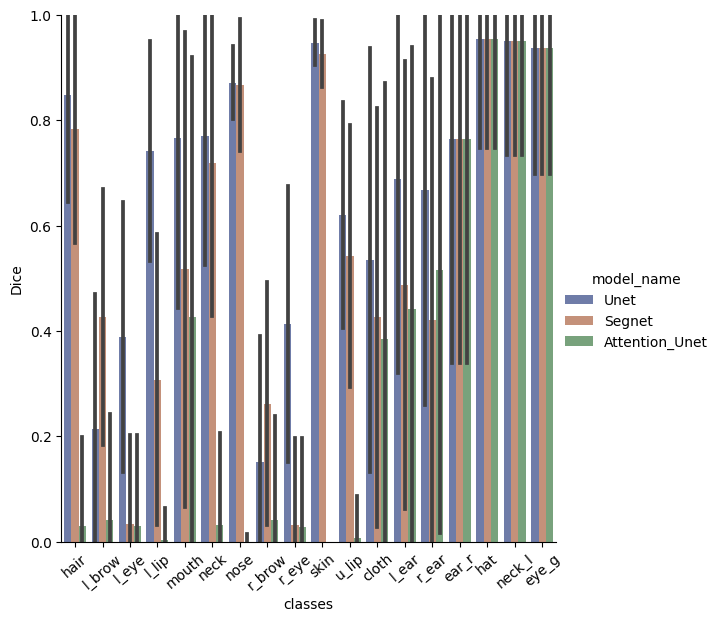

In [ ]:
import seaborn as sns
g=sns.catplot(
    data=df_model, kind="bar",
    x="classes", y="Dice", hue="model_name",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.set_xticklabels(rotation=40)
plt.ylim(0,1)
plt.show()

Based of dataset and catplot, I can conclude that standart Unet acrhitecture for 2 epochs of training performes better than Attention Unet and Segnet

#Results of segmentation

In [40]:
Unet_model_final = load_model_torch(Unet(3,18),name='Unet_8_weighted')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [27]:
res_Unet, dict_Dice_Unet, dict_IoU_Unet = test(Unet_model_final,test_dataloader,num_epochs=1)

100%|██████████| 5000/5000 [18:01<00:00,  4.62it/s]


In [30]:
df_Unet = get_DataSet_results(dict_Dice_Unet, 'Unet','Dice')

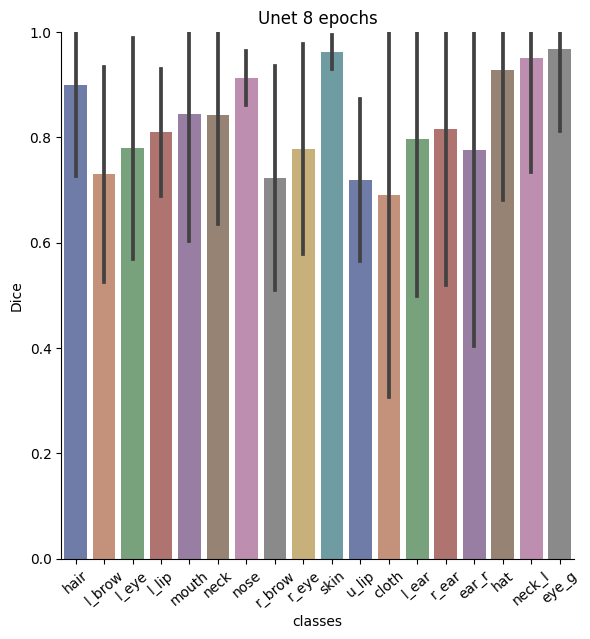

In [31]:
import seaborn as sns
g=sns.catplot(
    data=df_Unet, kind="bar",
    x="classes", y="Dice",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.set_xticklabels(rotation=40)
plt.title('Unet 8 epochs')
plt.ylim(0,1)
plt.show()

In [32]:
import itertools
import warnings

def show_result(model,mask,orig):
  mask, orig = mask.to('cpu'), orig.to('cpu')
  model = model.to('cpu')
  pred = model(orig)
  pred = 1*(pred>0.5)
  for i in range(len(mask)):
    colored_mask_0 = mask_colored(color_comb=color_comb,mask=mask[i])
    colored_pred_0 = mask_colored(color_comb=color_comb,mask=pred[i])
    show_masks(orig[i],colored_mask_0,colored_pred_0)
    plt.show()

#combinations for different classes
colors = {'r':[0,0.99,0.5],
          'g':[0.2,0.99,0.4],
          'b':[0,0.4,0.99]}
color_comb = []
for comb in itertools.product(*colors.values()):
  color_comb.append(comb)

#paints a tensor
def mask_colored(mask,color_comb=color_comb):
  mask.to('cpu')
  result_tensor_mask = torch.zeros(3,256,256)
  for i,part in enumerate(mask):
    tensor = torch.zeros(3,256,256)
    tensor[0] = color_comb[i][0]*part#r
    tensor[1] = color_comb[i][1]*part#g
    tensor[2] = color_comb[i][2]*part#b
    result_tensor_mask += tensor
    #plt.imshow(result_tensor_mask.detach().numpy().transpose((1, 2, 0)))
  return result_tensor_mask.clamp(0,1)

#plots
def show_masks(original,mask_1,mask_2=None):
  warnings.filterwarnings("ignore")
  if mask_2!=None:
    pics = [original,mask_1,mask_2]
    labels = ['original','mask','generated']
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
  else:
    pics = [original,mask_1]
    labels = ['original','generated']
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
  for title,pic,ax in zip(labels,pics,ax.flat):
    ax.imshow(pic.cpu().detach().numpy().transpose((1, 2, 0)))
    ax.set_title(title)
    ax.set_axis_off()

In [33]:
def find_best_worst(res, model):
  sorted_res = sorted(res, key=lambda x: x[1])
  print('Type, (idx,Dice,Iou)')
  print('Worst:',sorted_res[0],sorted_res[1])
  print('Best:',sorted_res[-1],sorted_res[-2])

  #creating a df of worst and best pic

  worst=[df_test.iloc[sorted_res[0][0]],df_test.iloc[sorted_res[1][0]]]
  best=[df_test.iloc[sorted_res[-1][0]],df_test.iloc[sorted_res[-2][0]]]
  df_worst = pd.DataFrame(columns=['orig_link', 'segment_link', 'label'])
  df_best = pd.DataFrame(columns=['orig_link', 'segment_link', 'label'])

  for i in range(2):
    df_worst.loc[i] = worst[i]
    df_best.loc[i] = best[i]
  #creating dataloader of worst and best pic

  batch_size = 2
  best_dataset = FaceDataSet(df_best,type_df='Test')
  best_dataloader = DataLoader(best_dataset, batch_size=batch_size,num_workers=2)
  worst_dataset = FaceDataSet(df_worst,type_df='Test')
  worst_dataloader = DataLoader(worst_dataset, batch_size=batch_size,num_workers=2)

  orig_b,mask_b = next(iter(best_dataloader)) #best
  orig_w,mask_w = next(iter(worst_dataloader)) #worst
  print('Best_Result')
  show_result(model, mask_b, orig_b)
  print('Worst_Result')
  show_result(model, mask_w, orig_w)

Type, (idx,Dice,Iou)
Worst: (3580, 0.3599549457821778, 0.343003068717926) (3091, 0.4611626799146172, 0.39031744283803943)
Best: (193, 0.9531088103748446, 0.9146364082170929) (4391, 0.9520271355279001, 0.9138002207016976)
Best_Result


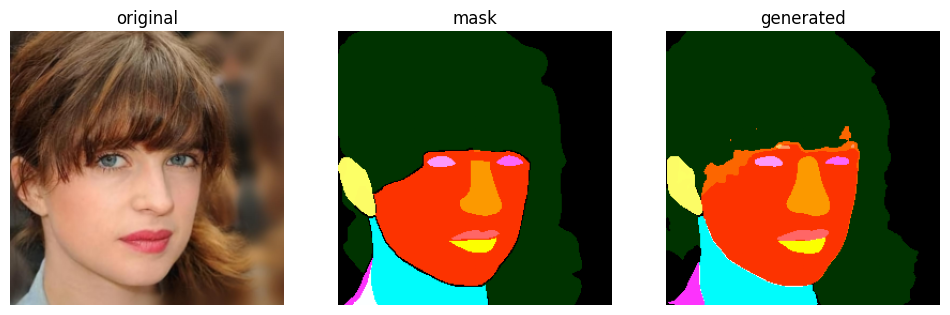

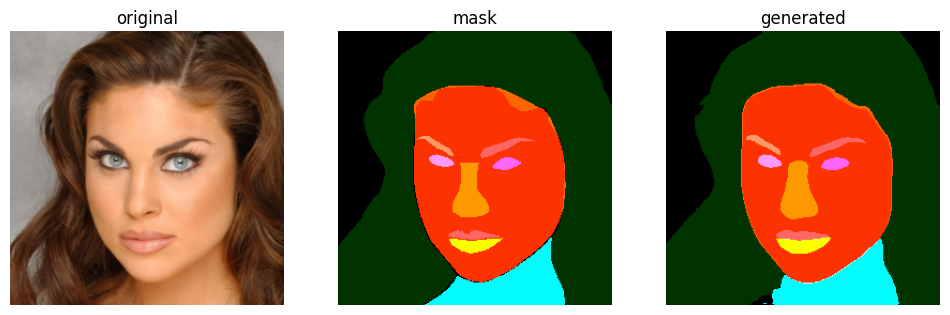

Worst_Result


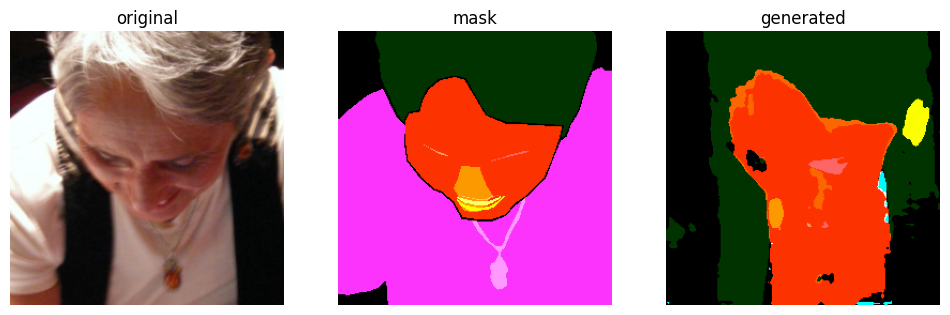

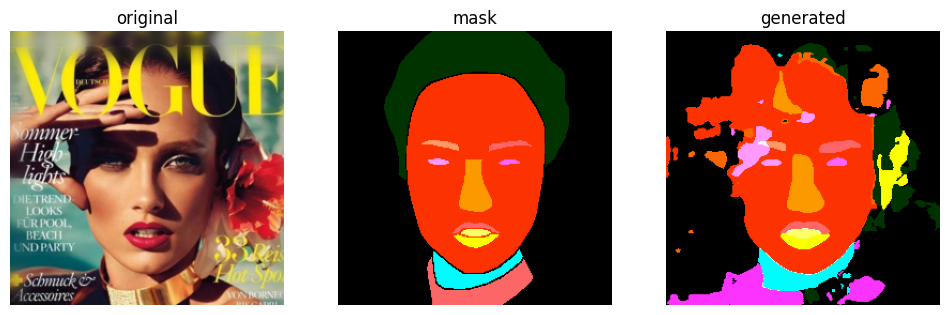

In [41]:
find_best_worst(res_Unet,Unet_model_final)

In [35]:
def dice_IoU_compare_dataset(dict_dice, dict_IoU):
  d = {'classes': [],
     'Dice' : [],
     'IoU': []}

  for (key, value) ,( _, value_IoU) in zip(dict_dice.items(), dict_IoU.items()):
    d['classes'] += [key] * len(value)
    d['Dice'] += value
    d['IoU'] += value_IoU

  df = pd.DataFrame(data=d)
  return df

In [36]:
df_IoU_Dice = dice_IoU_compare_dataset(dict_Dice_Unet, dict_IoU_Unet)
df_IoU_Dice.head()

,classes,Dice,IoU
0,hair,0.826947,0.704953
1,hair,0.970087,0.941912
2,hair,0.965293,0.932914
3,hair,0.974591,0.950441
4,hair,0.976684,0.954431


In [37]:
df_IoU_Dice.median()

Dice    0.907666
IoU     0.830942
dtype: float64

In next cell you will find a joint plot of Kernal Density plot with Histplot. As the result we see strong positive corellation between Dice and IoU

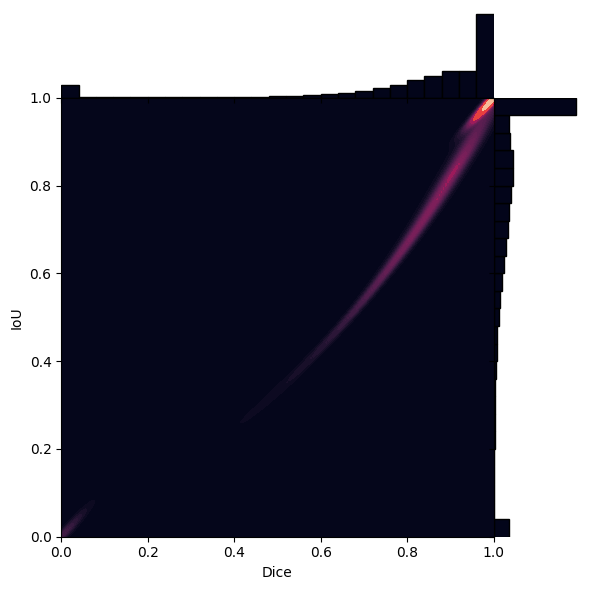

In [38]:
g = sns.JointGrid(data=df_IoU_Dice, x="Dice", y="IoU", space=0)
g.plot_joint(sns.kdeplot,fill=True, clip=((0, 1), (0, 1)),thresh=0, levels=20, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

#Check the perform of model on my photos

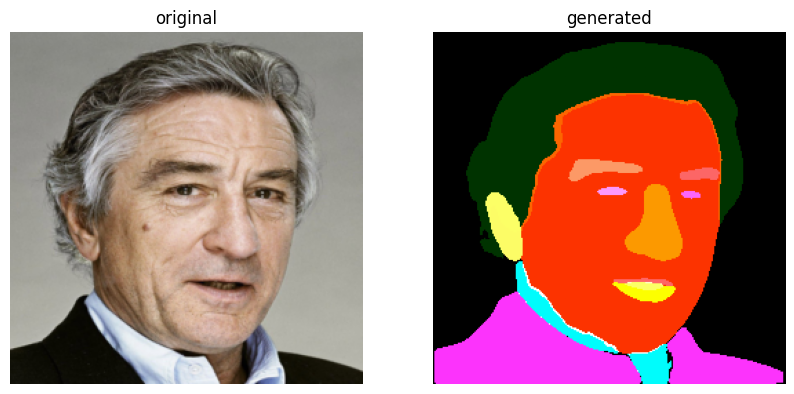

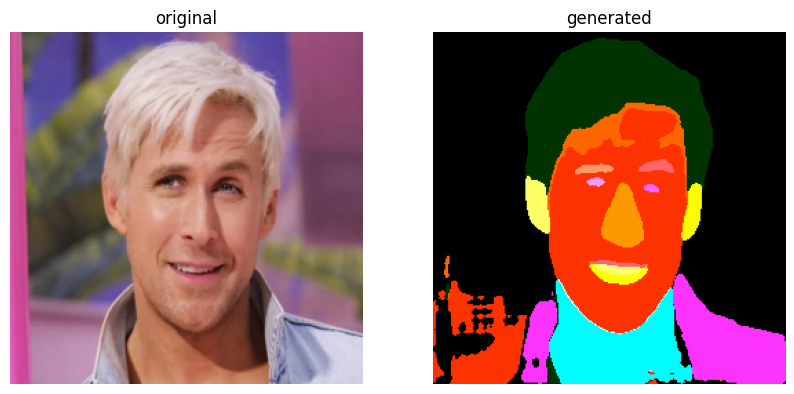

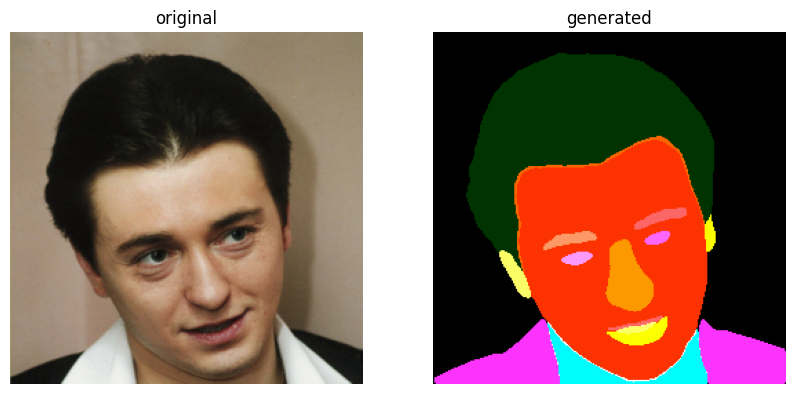

In [48]:
def own_picture(model,files):
  transform= transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ])
  pics=[]
  masks = []

  for pic in files:
    orig=(transform(Image.open(f'/content/drive/MyDrive/test_pic/{pic}'))).reshape((1, 3, 256, 256))
    pred=model(orig)
    mask=1*((pred)>0.5)
    mask_rgb = mask_colored(mask[0])
    show_masks(orig[0],mask_rgb)

own_picture(Unet_model_final,files=['me.jpg','also_me.jpg','again_me.jpg'])